# Animate Simulation

This notebook is used to animate the simulation.

In [1]:
import numpy as np
import pandas as pd
import scipy as sp

In [2]:
from simulation import NetworkSimulation

from environment import Environment
from location import Location

from importlib import reload
from matplotlib import animation, rc
from IPython.display import HTML

In [3]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
from msci.utils import utils
from msci.utils.utils import data_path
from msci.utils.plot import plot_histogram_jn, plot_path_jn

In [6]:
import copy
import datetime

from scipy.stats import gaussian_kde
from scipy.stats import linregress

In [7]:
from tqdm import tqdm_notebook as tqdm

## Setup the environment

The environement is an object which contains an area. The area is a list of lists.

### Create environment

In [8]:
shop_df = utils.import_shop_directory(mall='Mall of Mauritius', version=2)
shop_df.centroid = shop_df.centroid.apply(lambda x: x[1:-1].split(','))

In [9]:
shop_df.head()

,frequency,store_id,area,dimensions,centroid,x,y,count_of_shoppers
0,138233,B87,3345.833333,"{308.5: [69.0, 92.0], 309.5: [72.5, 104.0], 31...","[318.9785048914996, 89.388654180502002]",318.978505,89.388654,15744
1,48621,B247,1214.833333,"{225.0: [56.0, 56.0], 231.33333333333331: [46....","[246.72877631750342, 43.35011277705793]",246.728776,43.350113,6661
2,46538,B48,629.000000,"{128.0: [120.0, 131.0], 129.0: [119.0, 121.0],...","[118.1652126577564, 125.09122652456057]",118.165213,125.091227,4464
3,30784,B251,611.500000,"{256.0: [51.0, 58.0], 256.5: [52.0, 56.5], 258...","[266.81200190575197, 46.96101871101871]",266.812002,46.961019,5449
4,23494,B39,1718.500000,"{18.0: [102.0, 103.0], 19.0: [102.0, 103.0], 2...","[50.058532675009225, 106.37523764932889]",50.058533,106.375238,4711


In [10]:
environment_ = Environment(shop_df)

HBox(children=(IntProgress(value=0, max=126), HTML(value='')))

### Get Real Data - shoppers & mac addresses

In [11]:
mac_address_df = utils.import_mac_addresses(version=4)
signal_df = utils.import_signals(version=4)

c:\users\tvb\envs\venv-msci\lib\site-packages\IPython\core\interactiveshell.py:2850: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [12]:
shopper_df = mac_address_df[
    (mac_address_df.dbscan_label == 'Shopper') &
    (mac_address_df.wifi_type != 'lawifiuser')
]

In [13]:
shopper_df.start_time = pd.to_datetime(shopper_df.start_time)

c:\users\tvb\envs\venv-msci\lib\site-packages\pandas\core\generic.py:3110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [14]:
r_signal_df = pd.merge(
    signal_df[
        signal_df.store_id.notnull() & 
        (signal_df.store_id.str[0] == 'B') & 
        signal_df.mac_address.isin(shopper_df.mac_address)
    ], 
    shop_df[['store_id', 'x', 'y']], 
    on='store_id', 
    how='left',
    suffixes=('_actual', '')
)

r_shopper_df = shopper_df[shopper_df.mac_address.isin(r_signal_df.mac_address)]

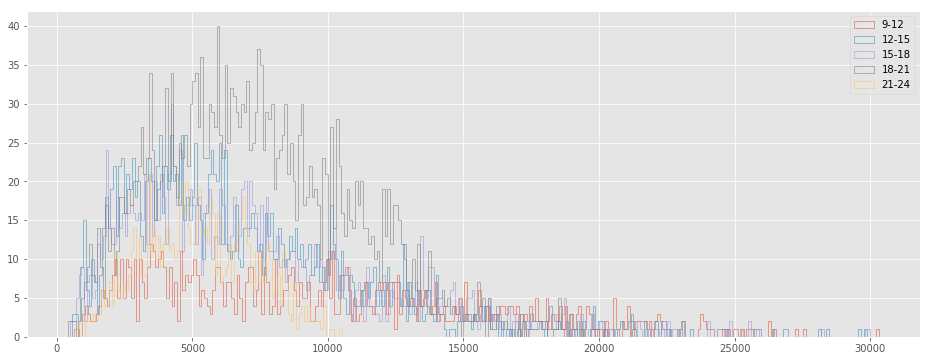

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 6))

binwidth = 100

data = r_shopper_df[
    (pd.datetime(2016, 12, 22, 9) < r_shopper_df.start_time) &
    (pd.datetime(2016, 12, 22, 12) > r_shopper_df.start_time)
].length_of_stay
ax.hist(data, bins=np.arange(min(data), max(data) + binwidth, binwidth), histtype='step', label='9-12');

data = r_shopper_df[
    (pd.datetime(2016, 12, 22, 12) < r_shopper_df.start_time) &
    (pd.datetime(2016, 12, 22, 15) > r_shopper_df.start_time)
].length_of_stay
ax.hist(data, bins=np.arange(min(data), max(data) + binwidth, binwidth), histtype='step', label='12-15');

data = r_shopper_df[
    (pd.datetime(2016, 12, 22, 15) < r_shopper_df.start_time) &
    (pd.datetime(2016, 12, 22, 18) > r_shopper_df.start_time)
].length_of_stay
ax.hist(data, bins=np.arange(min(data), max(data) + binwidth, binwidth), histtype='step', label='15-18');

data = r_shopper_df[
    (pd.datetime(2016, 12, 22, 18) < r_shopper_df.start_time) &
    (pd.datetime(2016, 12, 22, 21) > r_shopper_df.start_time)
].length_of_stay
ax.hist(data, bins=np.arange(min(data), max(data) + binwidth, binwidth), histtype='step', label='18-21');

data = r_shopper_df[
    (pd.datetime(2016, 12, 22, 21) < r_shopper_df.start_time) &
    (pd.datetime(2016, 12, 23, 0) > r_shopper_df.start_time)
].length_of_stay
ax.hist(data, bins=np.arange(min(data), max(data) + binwidth, binwidth), histtype='step', label='21-24');

ax.legend();

### Initiate the simulation

In [16]:
start_date_time = datetime.datetime(year=2016, month=12, day=22, hour=8, minute=30)
end_date_time = datetime.datetime(year=2016, month=12, day=23, hour=0)

In [17]:
environment = copy.deepcopy(environment_)

In [18]:
sim = NetworkSimulation(environment, max_shoppers=8050, start_date_time=start_date_time, end_date_time=end_date_time)

In [19]:
shop_markov_data = np.load(data_path + 'shop_markov_data.npz')

In [20]:
sim.A, sim.pi = environment.realign_transition_matrix(
    shop_markov_data['shop_names'], 
    shop_markov_data['transition_matrix'],
    shop_markov_data['initial_probabilities'],
)

### Create the distributions

In [21]:
length_of_stay_distribution = gaussian_kde((r_shopper_df.length_of_stay / 60).as_matrix())

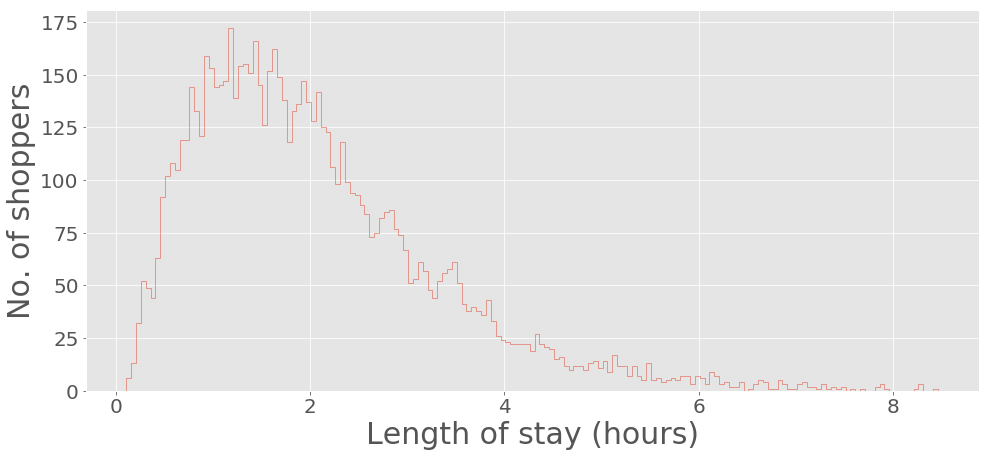

In [22]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 7))

binwidth = 0.05

data = (r_shopper_df.length_of_stay / 60 / 60).as_matrix()
ax.hist(data, bins=np.arange(min(data), max(data) + binwidth, binwidth), histtype='step');

ax.set_ylabel('No. of shoppers', fontsize=30)
ax.set_xlabel('Length of stay (hours)', fontsize=30);
ax.tick_params(labelsize=20)

# fig.savefig('length_of_stay_distribution.png', dpi=400)

In [23]:
arrival_distribution = gaussian_kde(
    (pd.to_datetime(r_shopper_df.start_time) - start_date_time).dt.round('15min').dt.total_seconds().as_matrix()
)

c:\users\tvb\envs\venv-msci\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


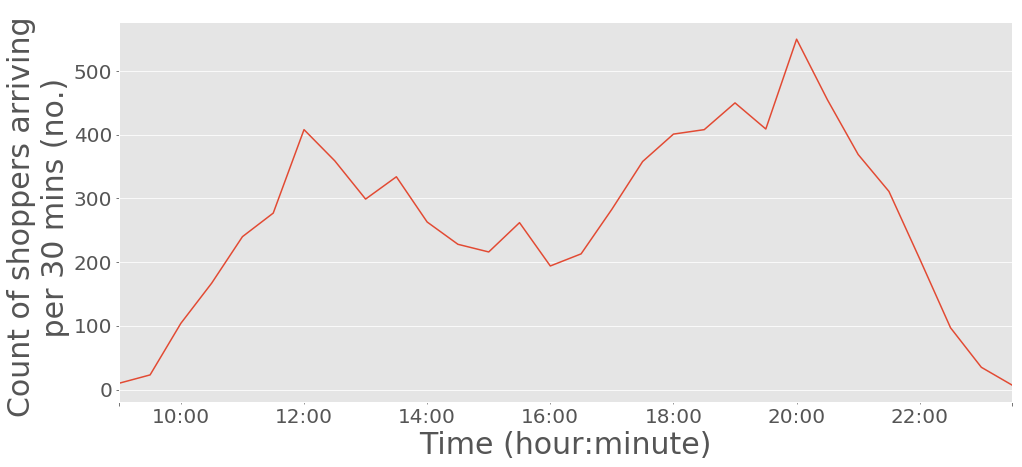

In [24]:
minute_resolution = 30

r_shopper_df['start_time_round'] = r_shopper_df.start_time.dt.round(str(minute_resolution) + 'min')
r_shopper_time_df = r_shopper_df[
    r_shopper_df.start_time_round > datetime.datetime(year=2016, month=12, day=22, hour=8, minute=30)
].groupby('start_time_round').mac_address.nunique().to_frame()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 7))

ax = r_shopper_time_df.plot(ax=ax, fontsize=20)
ax.set_xlabel('Time (hour:minute)', fontsize=30)
ax.set_ylabel('Count of shoppers arriving \n per {} mins (no.)'.format(minute_resolution), fontsize=30)
ax.legend_.remove();
ax.tick_params(labelsize=20)

# fig.savefig('start_time_distribution.png', dpi=400)

In [25]:
sim.length_of_stay_distribution = length_of_stay_distribution
sim.arrival_distribution = arrival_distribution

## Run the simulation

The simulation requires the maximum number of iterations (time) and the maximum number of shoppers (agents).

In [26]:
sim.iterate(max_iterations=1000)

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

## Histograms comparing Real vs simulated shoppers

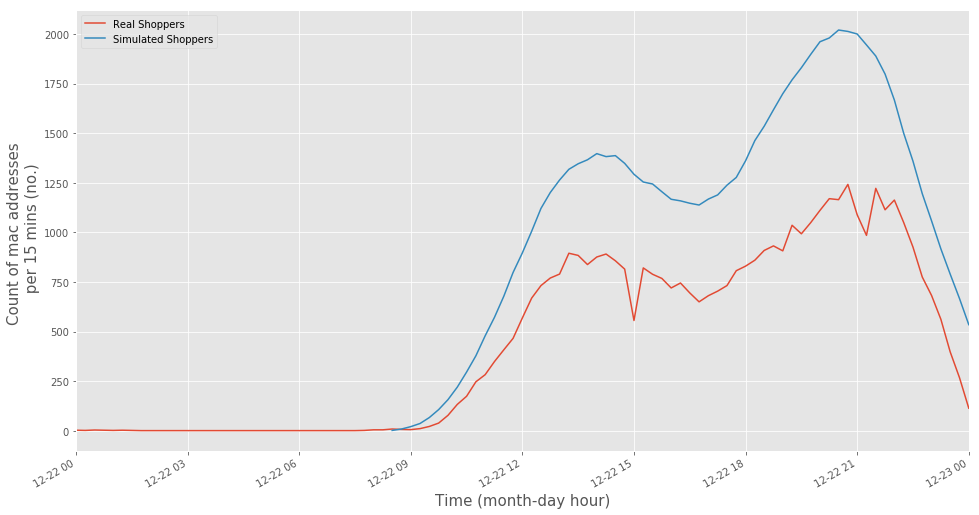

In [27]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 9))

plot_histogram_jn(
    r_signal_df[r_signal_df.mac_address.isin(r_shopper_df.mac_address)], 
    axes=ax,
    label='Real Shoppers',
)

plot_histogram_jn(
    sim.signal_df, 
    axes=ax,
    label='Simulated Shoppers',
);

# fig.savefig('real_sim.png', dpi=400)

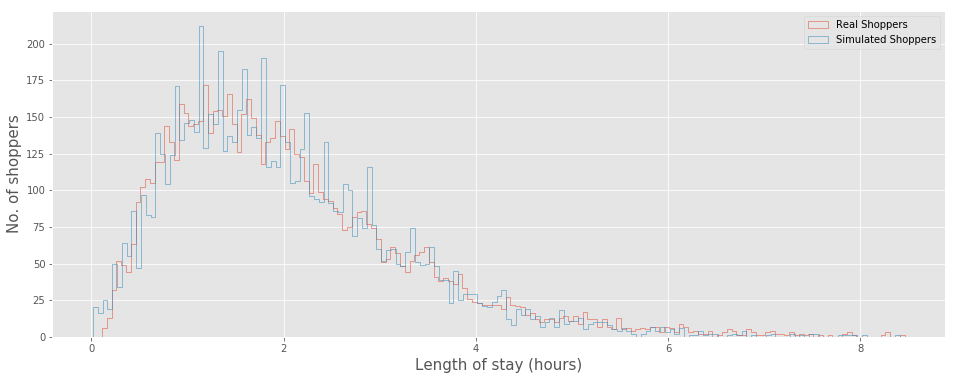

In [28]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 6))

binwidth = 0.05

data = (r_shopper_df.length_of_stay / 60 / 60).as_matrix()
ax.hist(data, bins=np.arange(min(data), max(data) + binwidth, binwidth), histtype='step', label='Real Shoppers');

data = (sim.mac_address_df.length_of_stay / 60 / 60).as_matrix()
ax.hist(data, bins=np.arange(min(data), max(data) + binwidth, binwidth), histtype='step', label='Simulated Shoppers');

ax.set_ylabel('No. of shoppers', fontsize=15)
ax.set_xlabel('Length of stay (hours)', fontsize=15)

ax.legend();

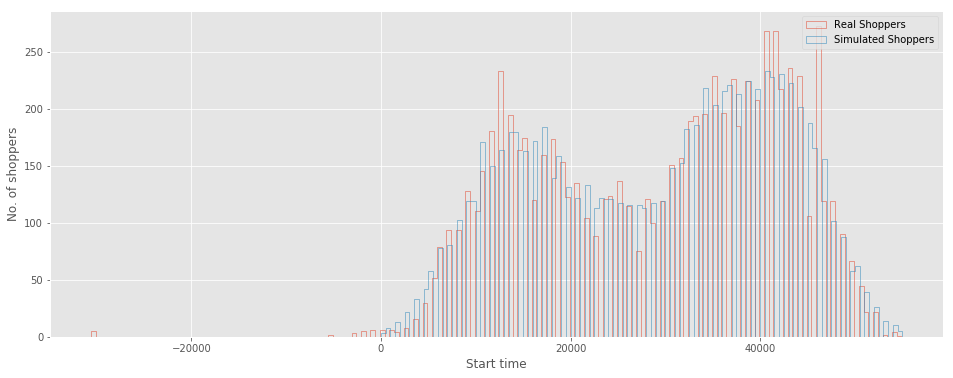

In [29]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 6))

binwidth = 500

start_time = min(pd.to_datetime(sim.mac_address_df.start_time))

data = (pd.to_datetime(r_shopper_df.start_time) - start_time).dt.round('15min').dt.total_seconds()
ax.hist(data, bins=np.arange(min(data), max(data) + binwidth, binwidth), histtype='step', label='Real Shoppers')


data = (pd.to_datetime(sim.mac_address_df.start_time) - start_time).dt.round('15min').dt.total_seconds()
ax.hist(data, bins=np.arange(min(data), max(data) + binwidth, binwidth), histtype='step', label='Simulated Shoppers');

ax.set_ylabel('No. of shoppers')
ax.set_xlabel('Start time')

ax.legend();

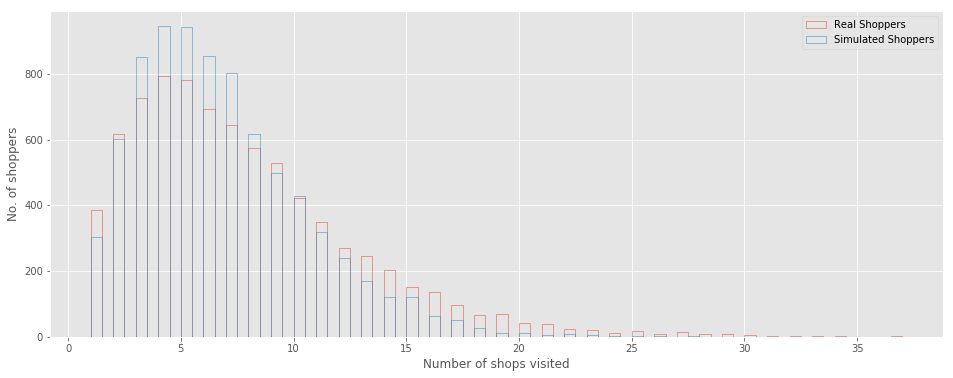

In [30]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 6))

binwidth = 0.5

data = r_shopper_df.number_of_shops.as_matrix()
ax.hist(data, bins=np.arange(min(data), max(data) + binwidth, binwidth), histtype='step', label='Real Shoppers')

data = sim.mac_address_df.number_of_shops.as_matrix()
ax.hist(data, bins=np.arange(min(data), max(data) + binwidth, binwidth), histtype='step', label='Simulated Shoppers');

ax.set_ylabel('No. of shoppers')
ax.set_xlabel('Number of shops visited')

ax.legend();

## Extract features

In [31]:
from msci.cleaning.features import calculate_radius_gyration, calculate_straightness, calculate_turning_angle

In [32]:
sim.mac_address_df['centroid'], sim.mac_address_df['radius_of_gyration'] = \
    calculate_radius_gyration(sim.signal_df, sim.mac_address_df, remove_consecutive=True)
    
r_shopper_df['centroid'], r_shopper_df['radius_of_gyration'] = \
    calculate_radius_gyration(r_signal_df, r_shopper_df, remove_consecutive=True)

HBox(children=(IntProgress(value=0, description='Radius of Gyration', max=8003), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Radius of Gyration', max=7965), HTML(value='')))

c:\users\tvb\envs\venv-msci\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


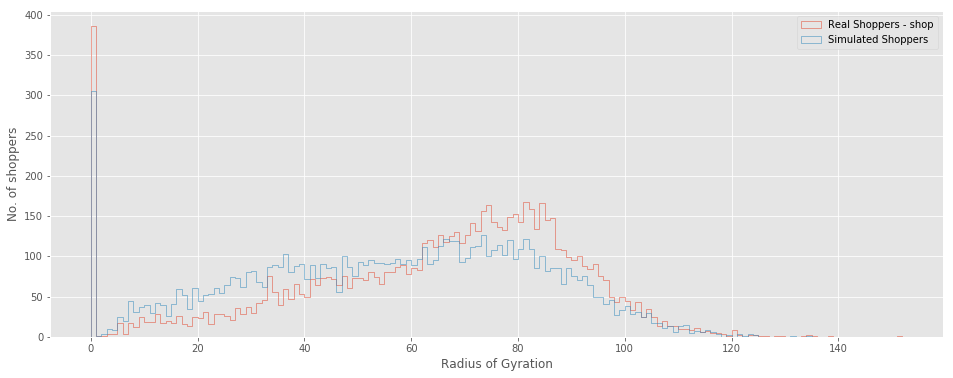

In [35]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 6))

binwidth = 1

data = r_shopper_df[r_shopper_df.radius_of_gyration.notnull()].radius_of_gyration.as_matrix()
ax.hist(data, bins=np.arange(min(data), max(data) + binwidth, binwidth), histtype='step', label='Real Shoppers - shop')

data = sim.mac_address_df[sim.mac_address_df.radius_of_gyration.notnull()].radius_of_gyration.as_matrix()
ax.hist(data, bins=np.arange(min(data), max(data) + binwidth, binwidth), histtype='step', label='Simulated Shoppers');

ax.set_ylabel('No. of shoppers')
ax.set_xlabel('Radius of Gyration')

ax.legend();

In [139]:
r_shopper_df['av_turning_angle'], r_shopper_df['total_turning_angle'], r_shopper_df['av_turning_angle_velocity'] = \
    calculate_turning_angle(r_signal_df, r_shopper_df, remove_consecutive=True)
    
sim.mac_address_df['av_turning_angle'], sim.mac_address_df['total_turning_angle'], sim.mac_address_df['av_turning_angle_velocity'] = \
    calculate_turning_angle(sim.signal_df, sim.mac_address_df, remove_consecutive=True)

HBox(children=(IntProgress(value=0, description='Turning Angle', max=7965), HTML(value='')))

c:\users\tvb\documents\repos\msci-complexity-project\msci\cleaning\features.py:186: RuntimeWarning: invalid value encountered in arccos
  mac_turning_angles = np.arccos(cos_angle)
c:\users\tvb\documents\repos\msci-complexity-project\msci\cleaning\features.py:187: RuntimeWarning: Mean of empty slice
  av_turning_angle = np.nanmean(mac_turning_angles)
c:\users\tvb\documents\repos\msci-complexity-project\msci\cleaning\features.py:192: RuntimeWarning: Mean of empty slice
  av_turning_angle_velocity = np.nanmean(mac_turning_angle_velocities)


c:\users\tvb\envs\venv-msci\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


HBox(children=(IntProgress(value=0, description='Turning Angle', max=8002), HTML(value='')))

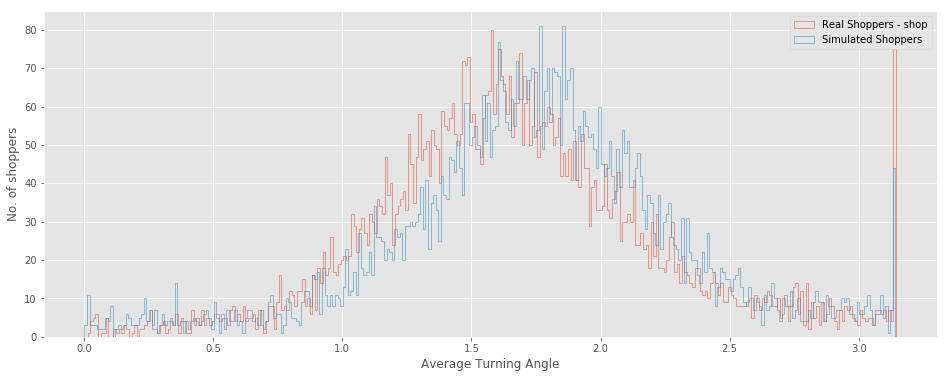

In [140]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 6))

binwidth = 0.01

data = r_shopper_df[r_shopper_df.av_turning_angle.notnull()].av_turning_angle.as_matrix()
ax.hist(data, bins=np.arange(min(data), max(data) + binwidth, binwidth), histtype='step', label='Real Shoppers - shop')

data = sim.mac_address_df[sim.mac_address_df.av_turning_angle.notnull()].av_turning_angle.as_matrix()
ax.hist(data, bins=np.arange(min(data), max(data) + binwidth, binwidth), histtype='step', label='Simulated Shoppers');

ax.set_ylabel('No. of shoppers')
ax.set_xlabel('Average Turning Angle')

ax.legend();

In [141]:
r_shopper_df['av_straightness'] = calculate_straightness(r_signal_df, r_shopper_df, remove_consecutive=True)
sim.mac_address_df['av_straightness'] = calculate_straightness(sim.signal_df, sim.mac_address_df, remove_consecutive=True)

HBox(children=(IntProgress(value=0, description='Straighness', max=7965), HTML(value='')))

c:\users\tvb\documents\repos\msci-complexity-project\msci\cleaning\features.py:267: RuntimeWarning: divide by zero encountered in true_divide
  mac_path_lengths = (mod(u) + mod(v)) / mod(t)
c:\users\tvb\documents\repos\msci-complexity-project\msci\cleaning\features.py:269: RuntimeWarning: Mean of empty slice
  av_straightness = np.nanmean(mac_path_lengths)


c:\users\tvb\envs\venv-msci\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


HBox(children=(IntProgress(value=0, description='Straighness', max=8002), HTML(value='')))

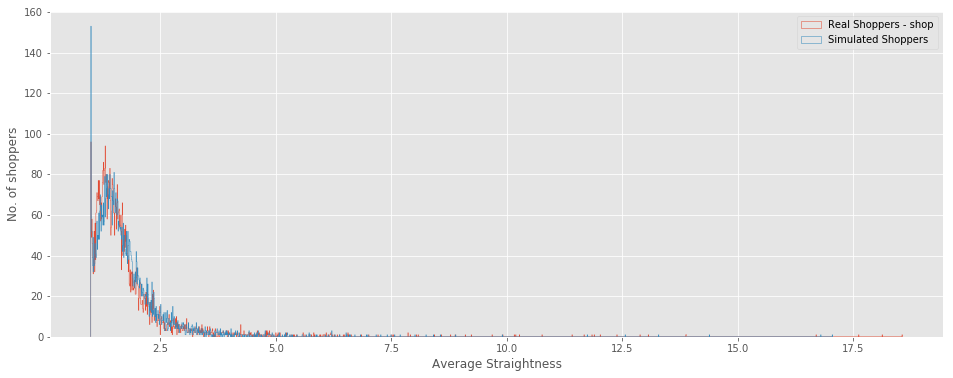

In [142]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 6))

binwidth = 0.01

data = r_shopper_df[r_shopper_df.av_straightness.notnull()].av_straightness.as_matrix()
ax.hist(data, bins=np.arange(min(data), max(data) + binwidth, binwidth), histtype='step', label='Real Shoppers - shop')

data = sim.mac_address_df[sim.mac_address_df.av_straightness.notnull()].av_straightness.as_matrix()
ax.hist(data, bins=np.arange(min(data), max(data) + binwidth, binwidth), histtype='step', label='Simulated Shoppers');

ax.set_ylabel('No. of shoppers')
ax.set_xlabel('Average Straightness')

ax.legend();

In [38]:
def add_count_of_shoppers(signal_df, shop_df):
    count_of_shoppers = []
    signal_group = signal_df.groupby('store_id')
    for shop in tqdm(shop_df.store_id.tolist(), desc='Count of shoppers'):
        try:
            group = signal_group.get_group(shop)
            count_of_shoppers.append(len(group.mac_address.unique()))
        except:
            count_of_shoppers.append(np.nan)
    return count_of_shoppers

In [39]:
shop_df['sim_count'] = add_count_of_shoppers(sim.signal_df, shop_df)
shop_df['act_count'] = add_count_of_shoppers(r_signal_df, shop_df)

HBox(children=(IntProgress(value=0, description='Count of shoppers', max=126), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Count of shoppers', max=126), HTML(value='')))

In [41]:
csfont = {'fontname':'Times New Roman'}
import matplotlib.font_manager as font_manager
font = font_manager.FontProperties(family='Times New Roman',style='normal', size=30)

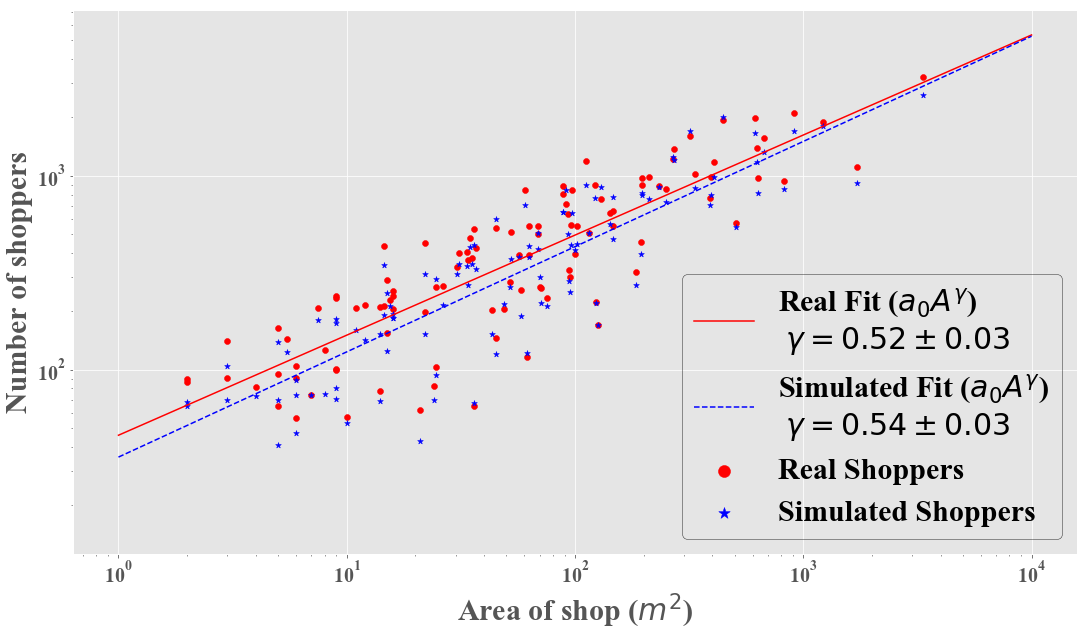

In [69]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 10))

area_shop_df = shop_df[
    (shop_df.area > 1) & 
    (shop_df.act_count > 50) & 
    (shop_df.sim_count > 0)
]

ax.scatter(area_shop_df.area, area_shop_df.act_count, label='Real Shoppers', c='r', marker='o')
slope, intercept, x_value, p_value, std_err = linregress(
    np.log10(area_shop_df.area), np.log10(area_shop_df.act_count)
)
area_fit = np.linspace(1, 10**4, 10)
count_of_shoppers_fit = [10**intercept*x**slope for x in area_fit]
ax.plot(
    area_fit, count_of_shoppers_fit, 'r-', 
    label='Real Fit ($a_0A^{\gamma}$) \n $\gamma=%.2f \pm %.2f$' % (slope, std_err)
)

ax.scatter(area_shop_df.area, area_shop_df.sim_count, label='Simulated Shoppers', c='b', marker='*')
slope, intercept, x_value, p_value, std_err = linregress(
    np.log10(area_shop_df.area), np.log10(area_shop_df.sim_count)
)
area_fit = np.linspace(1, 10**4, 10)
count_of_shoppers_fit = [10**intercept*x**slope for x in area_fit]
ax.plot(
    area_fit, count_of_shoppers_fit, 'b--', 
    label='Simulated Fit ($a_0A^{\gamma}$) \n $\gamma=%.2f \pm %.2f$' % (slope, std_err)
)

ax.set_xlabel('Area of shop ($m^2$)', fontsize=30, **csfont)
ax.set_ylabel('Number of shoppers', fontsize=30, **csfont)
ax.legend(markerscale=2., prop=font, frameon=True, edgecolor='k', facecolor='none')
ax.set_xscale('log')
ax.set_yscale('log')
ax.tick_params(labelsize=20)
ax.set_xticklabels(ax.get_xticks(), csfont)
ax.set_yticklabels(ax.get_yticks(), csfont)
ax.set_xscale('log')
ax.set_yscale('log')

# fig.savefig('shoppers_vs_area_of_store.png', dpi=350)